In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dftpy.field import DirectField
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.ions import Ions
from dftpy.grid import DirectGrid
from dftpy.math_utils import ecut2nr
from ase import Atoms
from dftpy.math_utils import ecut2nr
from dftpy.api.api4ase import DFTpyCalculator

In [2]:
from dftpy.functional import LocalPseudo, Functional, TotalFunctional

In [3]:
path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': './Ag_AE_1_gbrv.psp8'}

In [4]:
alat = 1.2 #[1.15, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
atoms.set_cell([L, L, L])
ions = Ions.from_ase(atoms)

In [5]:
grid = DirectGrid(ecut=60, lattice=ions.cell, full=False)
rho = DirectField(grid=grid)
HARTREE = Functional(type='HARTREE')

In [ ]:
F = []
E = []
alats = [0.5, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0]#, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
for alat in alats:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    PSEUDO = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list_ngbrv_ag)
    core = PSEUDO.core_density
    KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core)
    XC = Functional(type='XC', name='LDA', core_density=core, libxc=False)
    HARTREE = Functional(type='HARTREE')
    
    funcDict = {'KE' :KE, 'XC' :XC, 'HARTREE' :HARTREE, 'PSEUDO' :PSEUDO}
    EnergyEvaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    rho = DirectField(grid=grid)
    rho[:] = ions.get_ncharges() / ions.cell.volume
    # print(rho.grid.nr, core.grid.nr)
    opt_options = {'econv' : 1e-6, "maxiter": 600}
    optimizer = Optimization(EnergyEvaluator=EnergyEvaluator, optimization_options = opt_options, optimization_method='CG')
    
    calc = DFTpyCalculator(optimizer = optimizer, evaluator = EnergyEvaluator, rho = rho)
    
    atoms.calc =calc
    # F.append(atoms.get_forces())
    E.append(atoms.get_total_energy())


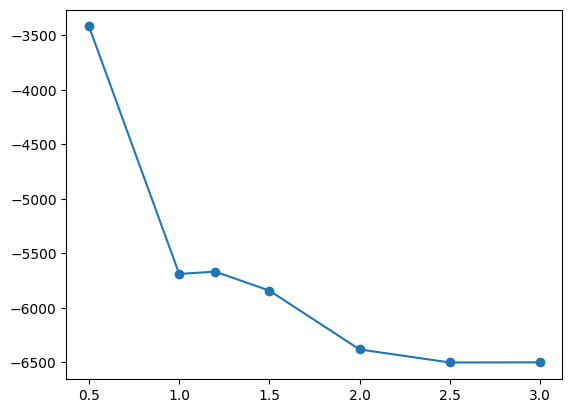

In [7]:
plt.plot(alats[0:],E[0:])
plt.scatter(alats[0:],  np.asarray(E[0:]))

In [32]:
from dftpy.functional.functional_output import FunctionalOutput
energypotential = {'TOTAL' : FunctionalOutput(name ='TOTAL', energy = 0.0)}

In [105]:
# Function in DFTpyCalculator to play with how to add the core in KE
def get_energy(EnergyEvaluator, rho, calcType={"E","V"}, split = False, **kwargs):
    print('init')
    energy_potential = {}
    energy_potential["TOTAL"] = FunctionalOutput(name="TOTAL", energy=0.0)
    for key, func in EnergyEvaluator.funcDict.items():
        
        # print(key, func.name)
        if split :
            if func.type == "KEDF":
                print('1')
                results = func(rho, calcType=calcType, split=split)
                print(func.name)
                if func.core_density is not None: print('THere is core in KE')
                for key2 in results:
                    k = "KEDF-" + key2.split('-')[-1]
                    energy_potential[k] = results[key2] + energy_potential.get(k, None)
                    energy_potential["TOTAL"] += results[key2]
            else :
                print('2')
                results = func(rho, calcType=calcType, **kwargs)
                if key =='KE' and key=='XC':     
                    if func.core_density is not None: print('THere is core in', key)
                energy_potential[func.type] = results
                energy_potential["TOTAL"] += results
        else :
            print(key)
            if key =="KE" and key=="XC":
                print(key)
            if key is not 'HARTREE':
                print(key, func.core_density.shape)
            results = func(rho, calcType=calcType, **kwargs)
            energy_potential["TOTAL"] += results
    #
    if EnergyEvaluator.ewald :
        results = FunctionalOutput(name="II", energy=EnergyEvaluator.ewald.energy)
        if split : energy_potential["II"] = results
        energy_potential["TOTAL"] += results
    #
    if 'E' in calcType:
        keys, ep = zip(*energy_potential.items())
        values = [item.energy for item in ep]
        values = rho.mp.vsum(values)
        for key, v in zip(keys, values):
            energy_potential[key].energy = v
    if not split : energy_potential = energy_potential["TOTAL"]
    return energy_potential
